Done


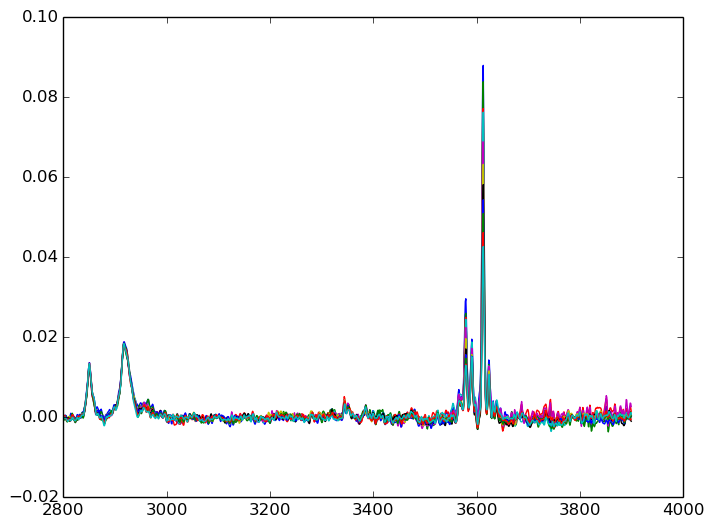

In [3]:
using PyPlot
using JuMP
using Ipopt
using Spectra

# you need to modify the following three lines
data = readdlm("./data/Fo_exp6_P5.txt", '\t') #reading the data
parameters = readdlm("./data/Fo_exp6_P5_params.txt", '\t') #reading the parametersthe experience details
plot(data[find(2800 .< data[:,1] .<3900),1],data[find(2800 .< data[:,1] .<3900),25:35]) # to select the point of departure of the profil more easily


step = Float64(parameters[1,2]) #step is inputed in metre
time = Float64(parameters[2,2].*3600.0) #time is in seconds, convert the hours of the user input
start_sp = Int64(parameters[3,2]) #first valid spectra along profil (at the border)
stop_sp = Int64(parameters[4,2]) #last valid spectra along profil (at the centre)
low_x = Float64(parameters[5,2]) #low frequency of roi (region of interest)
high_x = Float64(parameters[6,2]) #high frequency of roi (region of interest)
first_bound_norm = Float64(parameters[7,2]) #low bond of integration for normalisation
second_bound_norm = Float64(parameters[8,2]) #high bond of integration for normalisation
first_bound_err = Float64(parameters[9,2]) #low bond of integration for error estimation
last_bound_err = Float64(parameters[10,2]) #high bond of integration for error estimation
m = Int64(parameters[11,2]) #number_peaks
# We read the array of the model parameters and suqeeze them in 1D to have vectors
c0_guess = squeeze(readdlm(IOBuffer(parameters[12,2]),','),1) #Initial concentrations
c1_guess = squeeze(readdlm(IOBuffer(parameters[13,2]),','),1) #Bondary concentrations
D_guess = squeeze(readdlm(IOBuffer(parameters[14,2]),','),1) #Diffisivity coefficients
freq_guess = squeeze(readdlm(IOBuffer(parameters[15,2]),','),1) #Frequencies of the peaks
hwhm_guess = squeeze(readdlm(IOBuffer(parameters[16,2]),','),1) #HWHM of the peaks




println("Done")


In [59]:
# We prepare the data for the fit
x, y, y_ese_r, x_fit, y_fit, ese_fit = IRdataprep(data,step,start_sp,stop_sp,low_x,high_x,first_bound_norm,second_bound_norm, first_bound_err, last_bound_err)
println("Done")

Done


In [60]:
# number of data =
n = size(x_fit)[1]

mod = Model(solver=IpoptSolver(print_level=0))

#Initial values, remember that m is the number of peaks
@defVar(mod,g_co[i=1:m] )
@defVar(mod,g_c1[i=1:m] )
@defVar(mod, g_D[i=1:m] )
@defVar(mod, g_freq[i=1:m] )
@defVar(mod, g_hwhm[i=1:m] )

#Change the following parameters to adjust the model
setValue(g_co[i=1:m],c0_guess)
setValue(g_c1[i=1:m],c1_guess)
setValue(g_D[i=1:m],D_guess)
setValue(g_freq[i=1:m],freq_guess)
setValue(g_hwhm[i=1:m],hwhm_guess)

# The expression
@defNLExpr(g_mod[j=1:n],sum{((g_c1[i] - g_co[i]) * erfc(x_fit[j,1]/(2. * sqrt( 10^g_D[i] * time))) + g_co[i]) *exp(-log(2) * ((x_fit[j,2]-g_freq[i])/g_hwhm[i])^2), i=1:m}) 

# The objective function to solve
@setNLObjective(mod,Min,sum{(g_mod[j] - y_fit[j])^2, j=1:n})
println("Constructed...")

Constructed...


We now plot the data to see how looks like the initial model. If not good, we update the above values.

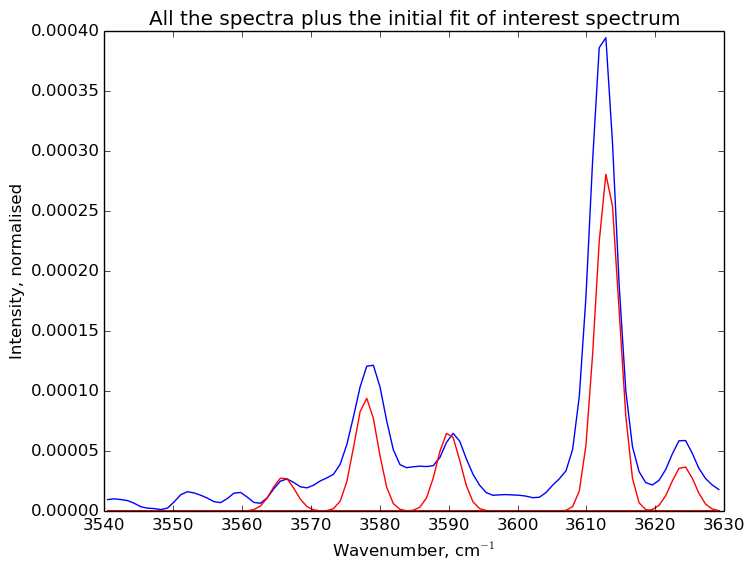

PyObject <matplotlib.text.Text object at 0x7f286e3d0d90>

In [62]:
# parameter extractions
mod_co = getValue(g_co)
mod_c1 = getValue(g_c1)
mod_D = getValue(g_D)
mod_f = getValue(g_freq)
mod_hwhm = getValue(g_hwhm)

selected_spectrum = 1 #for peak fitting figures
model,peaks = peak_diffusion(mod_co, mod_c1, mod_D, mod_f, mod_hwhm, x_fit, time)
interest_compos = peaks[selected_spectrum*length(x)+1:selected_spectrum*length(x)+length(x),:]

fig = figure()
#plot(x, y[:,:],color="black",label="All profil")
plot(x, y[:,selected_spectrum],color="blue",label="SOI")
plot(x,interest_compos[:,:],color="red",label="Guess fit")
title("All the spectra plus the initial fit of interest spectrum")
xlabel(L"Wavenumber, cm$^{-1}$")
ylabel("Intensity, normalised")


And we launch the optimisation procedure with the Ipopt algorithm.

In [63]:
# Solve for the control and state
println("Solving...")
status = solve(mod)

# Display results
println("Solver status: ", status)
println("rmsd: ", getObjectiveValue(mod))

Solving...
Solver status: Optimal
rmsd: 2.826595690052702e-7


We have a good solution. Let's see now how things look like:

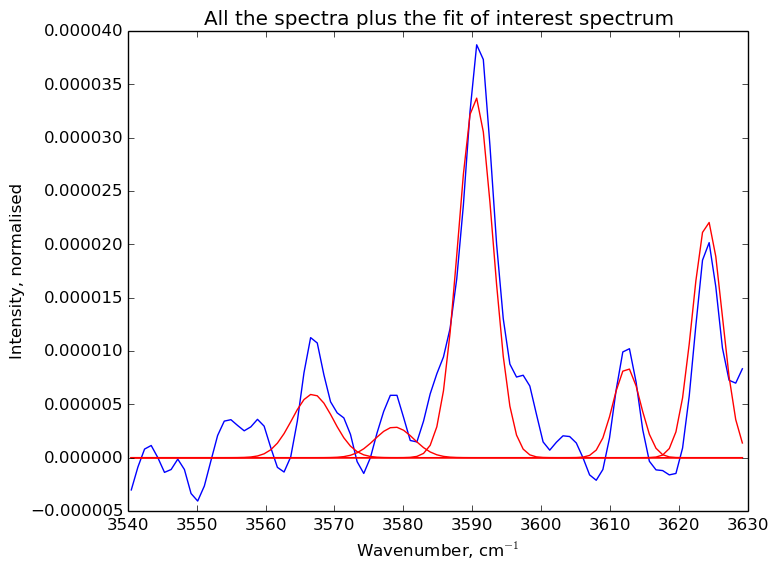

PyObject <matplotlib.text.Text object at 0x7f28716a8510>

In [67]:
# parameter extractions
mod_co_f = getValue(g_co)
mod_c1_f = getValue(g_c1)
mod_D_f = getValue(g_D)
mod_f_f = getValue(g_freq)
mod_hwhm_f = getValue(g_hwhm)

selected_spectrum = 80 #for peak fitting figures
model,peaks = peak_diffusion(mod_co_f, mod_c1_f, mod_D_f, mod_f_f, mod_hwhm_f, x_fit, time)
interest_compos = peaks[selected_spectrum*length(x)+1:selected_spectrum*length(x)+length(x),:]

fig = figure()
#plot(x, y[:,:],color="black",label="All profil")
plot(x, y[:,selected_spectrum],color="blue",label="SOI")
plot(x,interest_compos[:,:],color="red",label="Guess fit")
title("All the spectra plus the fit of interest spectrum")
xlabel(L"Wavenumber, cm$^{-1}$")
ylabel("Intensity, normalised")

In [68]:
println("c0 are $(mod_co_f)")
println("c1 are $(mod_c1_f)")
println("D are $(mod_D_f)")
println("frequency are $(mod_f_f)")
println("hwhm are $(mod_hwhm_f)")

c0 are [4.528924603356055e-6,2.445985779049112e-6,3.37219544158513e-5,5.5391237026879735e-6,2.2191435882624806e-5]
c1 are [2.7144998446605375e-5,0.00012772557821421864,7.057278038165616e-5,0.0004181401219409957,6.023807700548046e-5]
D are [-12.49302718917794,-12.887627328704028,-12.946166404886803,-12.814677233322632,-12.995150549593538]
frequency are [3566.8226118118755,3578.6997748717827,3590.4653319111276,3612.431270147926,3624.11208869922]
hwhm are [3.5034490781714913,3.3345067473650953,2.9809390648371714,2.347429633391399,2.543414894778261]


1141-element Array{Float64,1}:
 0.07136
 0.07392
 0.07624
 0.07696
 0.07573
 0.07351
 0.07124
 0.07047
 0.07163
 0.07295
 0.07362
 0.07349
 0.07243
 ⋮      
 1.16691
 1.13515
 1.07938
 1.0549 
 1.0455 
 1.02746
 1.00613
 1.01481
 1.05389
 1.09016
 1.10272
 1.08846